# An introduction to pitch-class sets and their equivalances

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
from IPython.display import Audio, display
import copy
from pathlib import Path

import librosa.display
import matplotlib.pyplot as plt
import music21
import pretty_midi
import seaborn as sns

from midi_set_class.midi import midi_to_df
from midi_set_class.notation import (
    midipitch_to_scientific,
    scientific_to_midipitch,
    midipitch_to_pitchclass,
)

## Get data 

First let's get some midi. There's some example midi at [abcplus.sourceforge.net](http://abcplus.sourceforge.net/):
* https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip

Download it and unzip adjacent to this notebook.

In [3]:
! wget https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip
! unzip abcplus_en-2019-12-20.zip

--2020-08-26 19:50:43--  https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip
Resolving sourceforge.net (sourceforge.net)... 216.105.38.13
Connecting to sourceforge.net (sourceforge.net)|216.105.38.13|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip/ [following]
--2020-08-26 19:50:44--  https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip/download [following]
--2020-08-26 19:50:44--  https://sourceforge.net/projects/abcplus/files/Abcplus/abcplus_en-2019-12-20.zip/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/proj

In [4]:
midi_path = Path("abcplus_en-2019-12-20", "amazinggrace.mid")
note_df = midi_to_df(midi_path)
note_df["pitch_sci"] = note_df.pitch.apply(midipitch_to_scientific)
note_df["pitchclass"] = note_df.pitch.apply(midipitch_to_pitchclass)
note_df.head()

onset  track  pitch   duration  velocity pitch_sci  pitchclass
0  0.007812      1     43  49.691406        70        G2           7
1  0.011719      1     31  49.687500        70        G1           7
2  4.691406      0     62   0.933594        80        D4           2
3  5.628906      0     69   0.054688       105        A4           9
4  5.687500      0     67   1.812500        80        G4           7

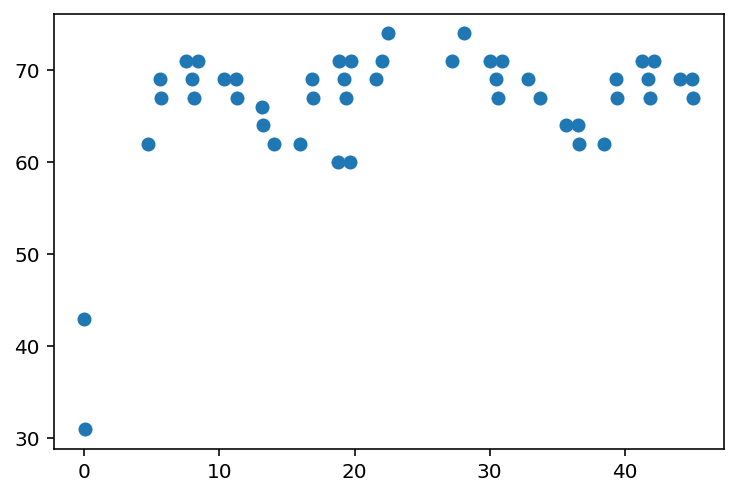

In [5]:
plt.scatter(note_df.onset, note_df.pitch)

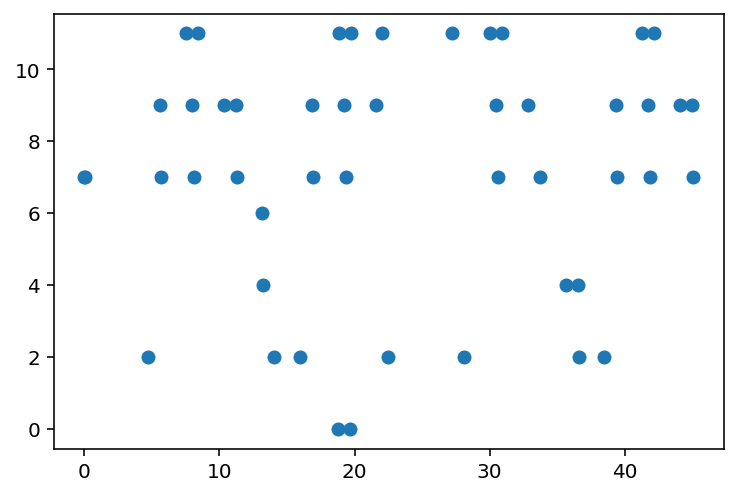

In [6]:
plt.scatter(note_df.onset, note_df.pitchclass)

In [21]:
def pitchclass_interval(pc_from, pc_to, ordered=True):
    if ordered:
        interval = (pc_to - pc_from) % 12
    else:
        interval = min(
            (pc_to - pc_from) % 12,
            (pc_from - pc_to) % 12
        )
    return interval

In [29]:
pc_list = note_df.pitchclass.tolist()
pc_int_ordered = [
    pitchclass_interval(ff, tt) for ff, tt in zip(pc_list[:-1], pc_list[1:])
]
pc_int = [
    pitchclass_interval(ff, tt, ordered=False) for ff, tt in zip(pc_list[:-1], pc_list[1:])
]

In [60]:
midi_data = pretty_midi.PrettyMIDI(str(midi_path))

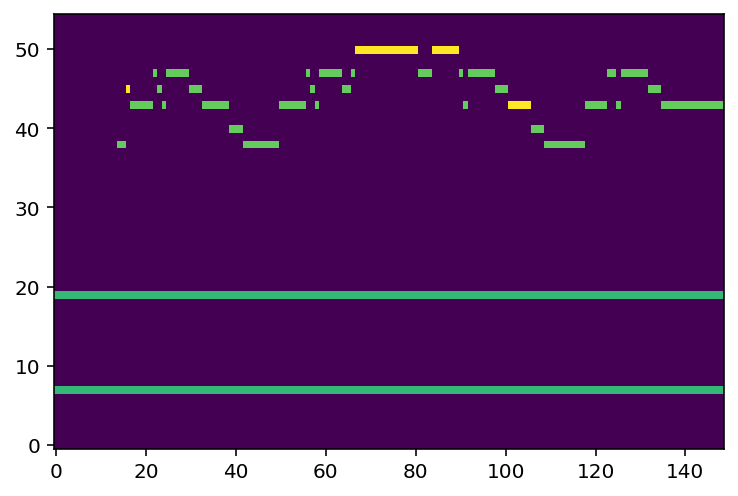

In [71]:
min_pitch = scientific_to_midipitch("C1")
max_pitch = scientific_to_midipitch("G5")
fs = 3
piano_roll = midi_data.get_piano_roll(fs)[min_pitch:max_pitch]
plt.imshow(piano_roll, origin="lower", aspect="auto")

In [72]:
new_md = copy.deepcopy(midi_data)
for instrument in new_md.instruments:
    for note in instrument.notes:
        note.pitch = midipitch_to_pitchclass(note.pitch)

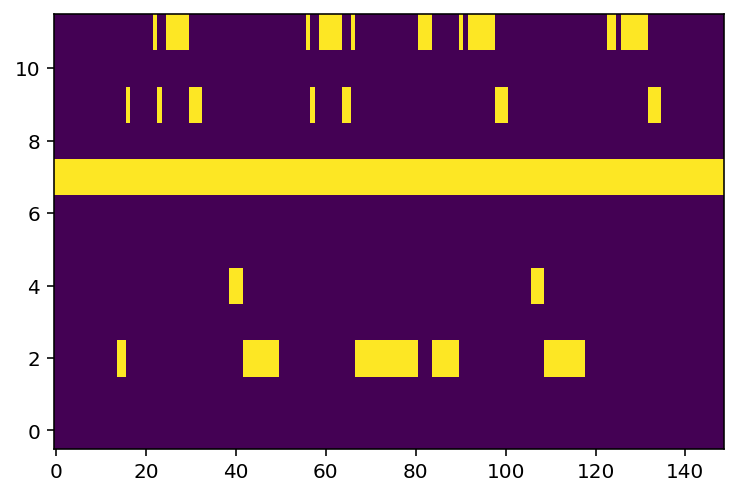

In [73]:
fs = 3
pc_piano_roll = (new_md.get_piano_roll(fs)[:12] > 0).astype(int)
plt.imshow(pc_piano_roll, origin="lower", aspect="auto")

In [74]:
# TODO: remove the pedal and check how things change

## Partitioning

We must find every point in the piece where the pitch class set can potentially change - every note_on and note_off - then get the pitchclass set within each interval.

In [75]:
pitchclasses_on = set()
note_off = []
for row in note_df[["onset", "duration", "pitchclass"]].itertuples(index=False, name=None):
    onset, duration, pitchclass = row
    

0.0078125
0.01171875
4.69140625
5.62890625
5.6875
7.50390625
7.97265625
8.12890625
8.44140625
10.31640625
11.25390625
11.3125
13.12890625
13.1875
14.06640625
15.94140625
16.87890625
16.9375
18.75390625
18.8125
19.22265625
19.37890625
19.69140625
19.75
21.56640625
22.03515625
22.50390625
27.19140625
28.12890625
30.00390625
30.47265625
30.62890625
30.94140625
32.81640625
33.75390625
35.62890625
36.56640625
36.625
38.44140625
39.37890625
39.4375
41.25390625
41.72265625
41.87890625
42.19140625
44.06640625
45.00390625
45.0625


In [42]:
# 1. pass through getting pitchclasses for every note: N
N = 6
pc_list = note_df.pitch.apply(midipitch_to_pitchclass).tolist()
pc_list

[2, 9, 7, 11]

In [43]:
# 2. get the unordered pitchclass_interval for every pair of notes:  N(N-1)/2
pc_int = {}
for ii in range(len(pc_list)):
    for jj in range(ii+1, len(pc_list)):
        pc_int[(ii, jj)] = pitchclass_interval(pc_list[ii], pc_list[jj], ordered=False)
pc_int

{(0, 1): 5, (0, 2): 5, (0, 3): 3, (1, 2): 2, (1, 3): 2, (2, 3): 4}

In [46]:
# 3. for every pair of notes, get the set of intervals between them: N(N-1)/2
pc_int_set = {}
for ii in range(len(pc_list)):
    this_pc_int_set = set()
    for jj in range(ii+1, len(pc_list)):
        this_pc_int_set.add(pc_int[ii, jj])
        pc_int_set[(ii, jj)] = this_pc_int_set.copy()
pc_int_set

{(0, 1): {5},
 (0, 2): {5},
 (0, 3): {3, 5},
 (1, 2): {2},
 (1, 3): {2},
 (2, 3): {4}}

In [18]:

note_df["pc_interval_ordered"] = note_df.pitchclass.
note_df["pc_interval"] = note_df.pic

In [20]:
display(note_df.head())
display(note_df.tail())

onset  track  pitch   duration  velocity pitch_sci  pitchclass  \
0  0.007812      1     43  49.691406        70        G2           7   
1  0.011719      1     31  49.687500        70        G1           7   
2  4.691406      0     62   0.933594        80        D4           2   
3  5.628906      0     69   0.054688       105        A4           9   
4  5.687500      0     67   1.812500        80        G4           7   

   pc_interval_ordered  
0                  0.0  
1                  5.0  
2                  5.0  
3                  2.0  
4                  8.0

onset  track  pitch  duration  velocity pitch_sci  pitchclass  \
43  41.878906      0     67  0.308594        80        G4           7   
44  42.191406      0     71  1.871094        80        B4          11   
45  44.066406      0     69  0.933594        80        A4           9   
46  45.003906      0     69  0.054688       105        A4           9   
47  45.062500      0     67  4.625000        80        G4           7   

    pc_interval_ordered  
43                  8.0  
44                  2.0  
45                  0.0  
46                  2.0  
47                  NaN

# Noodling

In [5]:
note_df = midi_to_df(midi_path)
note_df

onset  track  pitch   duration  velocity
0    0.007812      1     43  49.691406        70
1    0.011719      1     31  49.687500        70
2    4.691406      0     62   0.933594        80
3    5.628906      0     69   0.054688       105
4    5.687500      0     67   1.812500        80
5    7.503906      0     71   0.464844        80
6    7.972656      0     69   0.152344        80
7    8.128906      0     67   0.308594        80
8    8.441406      0     71   1.871094        80
9   10.316406      0     69   0.933594        80
10  11.253906      0     69   0.054688       105
11  11.312500      0     67   1.812500        80
12  13.128906      0     66   0.054688        80
13  13.187500      0     64   0.875000        80
14  14.066406      0     62   1.871094        80
15  15.941406      0     62   0.933594        80
16  16.878906      0     69   0.054688       105
17  16.937500      0     67   1.812500        80
18  18.753906      0     60   0.054688        80
19  18.812500      0     71   0.406250        80
20  19.222656      0     69   0.152344        80
21  19.378906      0     67   0.308594        80
22  19.691406      0     60   0.054688        80
23  19.750000      0     71   1.812500        80
24  21.566406      0     69   0.464844        80
25  22.035156      0     71   0.464844        80
26  22.503906      0     74   4.683594       105
27  27.191406      0     71   0.933594        80
28  28.128906      0     74   1.871094       105
29  30.003906      0     71   0.464844        80
30  30.472656      0     69   0.152344        80
31  30.628906      0     67   0.308594        80
32  30.941406      0     71   1.871094        80
33  32.816406      0     69   0.933594        80
34  33.753906      0     67   1.871094       105
35  35.628906      0     64   0.933594        80
36  36.566406      0     64   0.054688        80
37  36.625000      0     62   1.812500        80
38  38.441406      0     62   0.933594        80
39  39.378906      0     69   0.054688       105
40  39.437500      0     67   1.812500        80
41  41.253906      0     71   0.464844        80
42  41.722656      0     69   0.152344        80
43  41.878906      0     67   0.308594        80
44  42.191406      0     71   1.871094        80
45  44.066406      0     69   0.933594        80
46  45.003906      0     69   0.054688       105
47  45.062500      0     67   4.625000        80

<AxesSubplot:xlabel='duration'>

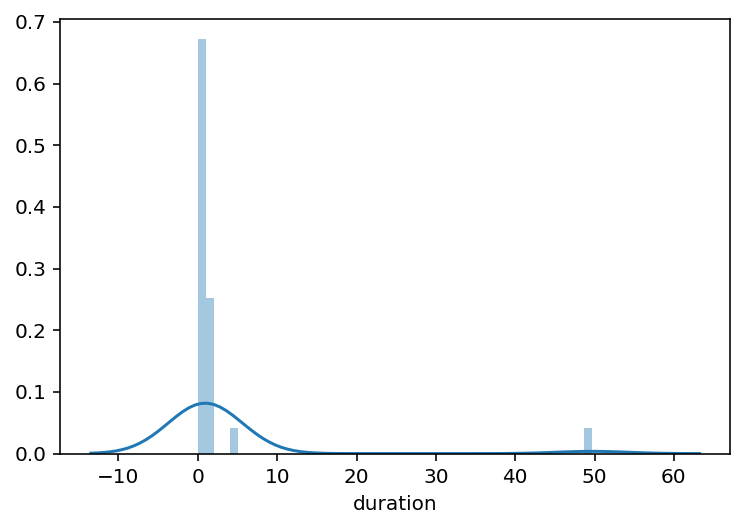

In [6]:
sns.distplot(note_df.duration)

<AxesSubplot:xlabel='duration'>

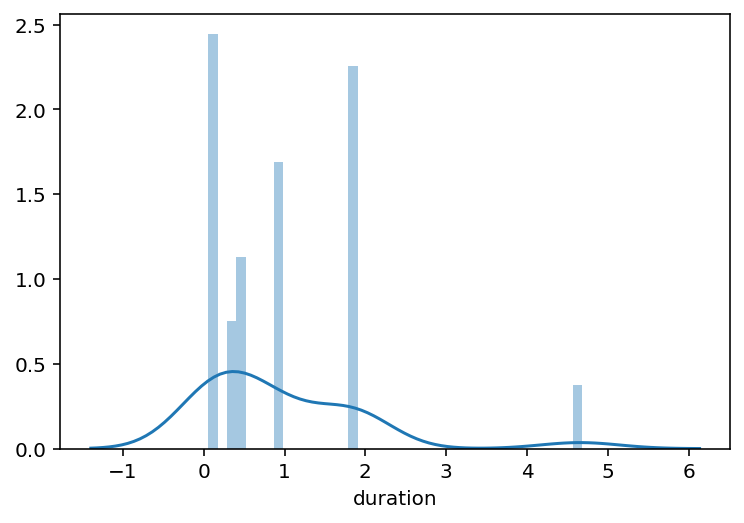

In [7]:
sns.distplot(note_df.duration.loc[note_df.duration < 10], bins=40)

In [8]:
midi_data = pretty_midi.PrettyMIDI(str(midi_path))

In [9]:
midi_data.estimate_tempo()

103.78378378378379

In [10]:
total_velocity = sum(sum(midi_data.get_chroma()))
print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

[0.0007434356951356074, 0.0, 0.11211010282644958, 0.0, 0.013976591068549418, 0.0, 0.0004460614170813644, 0.7622678505880112, 0.0, 0.031651774720398484, 0.0, 0.07880418368437438]


In [11]:
audio_data = midi_data.synthesize(fs=44100)

In [12]:
Audio(audio_data, rate=44100)

In [13]:
def plot_piano_roll(pm, min_pitch=None, max_pitch=None, fs=100):
    if min_pitch is None:
        min_pitch = scientific_to_midipitch("G3")
    if max_pitch is None:
        max_pitch = scientific_to_midipitch("G5")
    
    librosa.display.specshow(
        pm.get_piano_roll(fs)[min_pitch:max_pitch],
        hop_length=1,
        sr=fs,
        x_axis='time',
        y_axis='cqt_note',
        fmin=pretty_midi.note_number_to_hz(min_pitch),
    )

/Users/jfowers/opt/miniconda3/envs/midi-set-class/lib/python3.8/site-packages/librosa/display.py:1154: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(
/Users/jfowers/opt/miniconda3/envs/midi-set-class/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


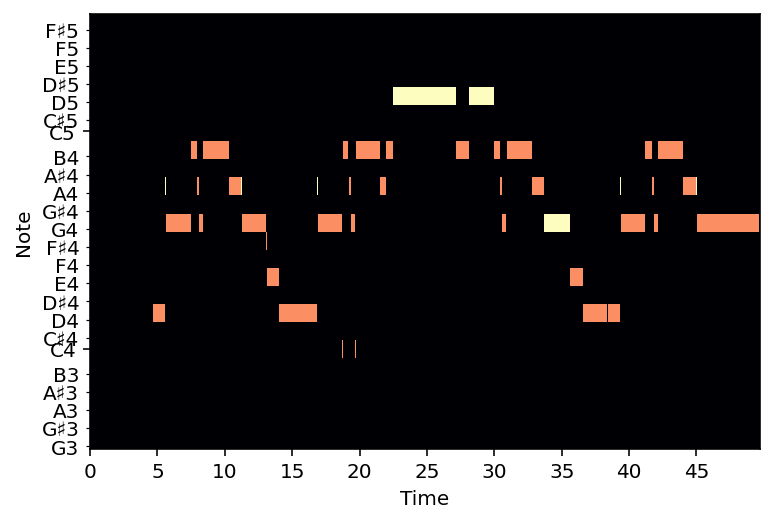

In [14]:
plot_piano_roll(midi_data)

looks like music21 wants data to be aligned...it's messed this up bad!

In [15]:
score = music21.converter.parse(str(midi_path))

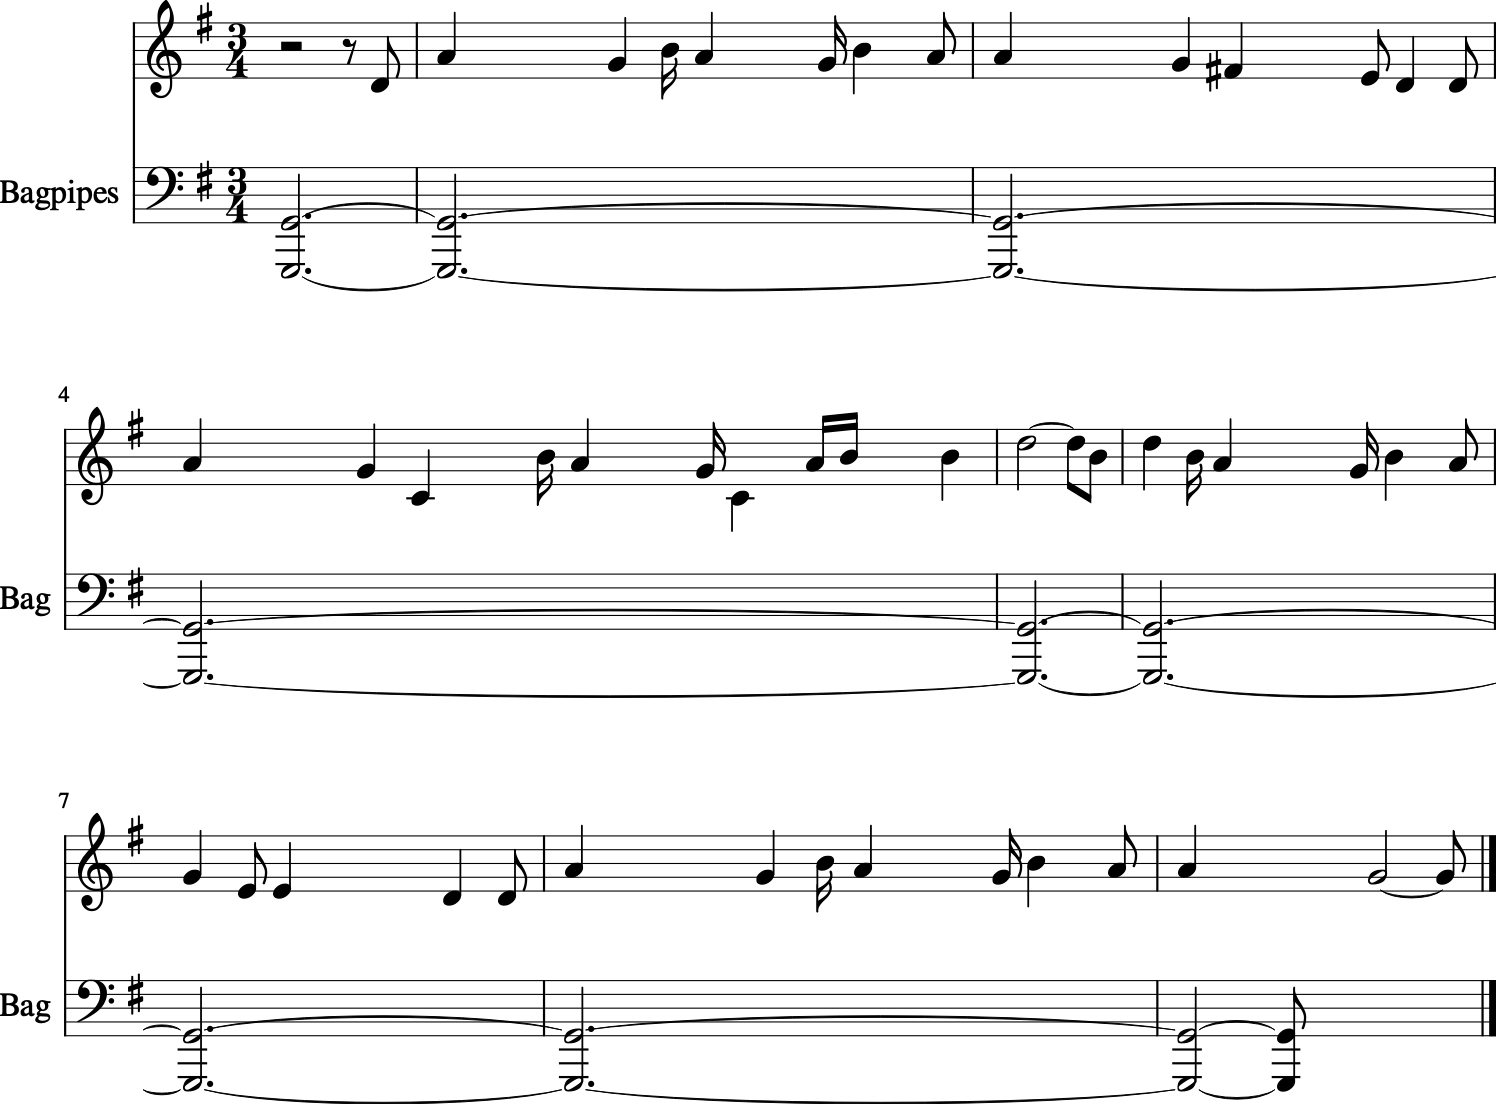

In [16]:
score.show()